# 적대적 생성 신경망(Generative Adversarial Networks, GAN)

- 2014년, Ian Goodfellow 소개

- VAE와는 다른 방법으로 이미지 잠재 공간을 학습

- 직관적으로 이해하는 방법

  - 가짜 피카소 그림을 그리는 위조범과 이를 판별하는 판매상의 관계

  - 위조품과 진짜 그림을 섞어서 판매상에게 보여주며  
    그림이 진짜인지 가짜인지 판매상은 판별하고 이를 위조범에게 피드백

  - 처음에는 형편없는 그림을 그리다가 점점 피카소의 스타일을 모방하게 되고  
    판매상은 위조품을 구분하는데 점점 더 전문가가 되어감

    - => 판매상과 위조범의 관계는 '**적대적**'!

- GAN의 네트워크

  - 생성자 네트워크(generator network)

    - 랜덤 벡터(잠재 공간의 무작위한 포인트)를 입력으로 받아 이를 합성된 이미지로 디코딩

  - 판별자 네트워크(discriminator netowrk)

    - 이미지(실제 또는 가짜 이미지)를 입력으로 받아 훈련 세트에서 온 이미지인지 생성자가 만든 이미지인지 판별

- GAN은 최적화의 최솟값이 고정되어 있지 않음

  - 보통의 경사하강법은 **고정된 손실공간**에서 언덕을 내려오는 훈련 방법이지만  
    GAN은 매 단계가 조금씩 전체 공간을 바꾸기 때문에 최적화 과정이 최솟값을 찾는 것이 어려움

  - 두 힘간의 평형점을 찾는 시스템

  - 따라서, 학습과정이 매우 어려움  
    즉, 적절한 파라미터를 찾고 조정해야함
  
  <img src="https://paperswithcode.com/media/methods/gan.jpeg">

  <sub>[이미지 출처] https://paperswithcode.com/method/gan</sub>

## GAN의 구현 (DCGAN)

- CIFAR10 데이터셋 사용

- generator 네트워크는 (latent_dim,) 크기의 벡터를 (32, 32, 3) 크기의 이미지로 매핑

- discriminator 네트워크는 (32, 32, 3) 크기의 이미지가 진짜일 확률을 추정하여 이진값으로 매핑

- 생성자와 판별자를 연결하는 gan 네트워크를 만듬  
  
  - gan(x) = discriminator(generator(x))

- 진짜/가짜 레이블과 함께 진짜 이미지와 가짜 이미지 샘플을 사용하여 판별자를 훈련 (일반적인 이미지 분류 모델 훈련과 동일)

- 생성자를 훈련하려면 gan 모델의 손실에 대한 생성자 가중치의 그래디언트를 사용

  - 매 단계마다 생성자에 의해 디코딩된 이미지를 판별자가 "진짜"로 분류하도록 한다는 방향으로 생성자의 가중치를 이동

  - 판별자를 속이도록 생성자를 훈련한다는 말

  - 생성자(위조범)은 치밀하게 판별자(판매상)를 속여야 하고,  
  판별자는 생성자와 원본 데이터의 차이를 알아낼 수 있도록 학습한 상태임.  
  이 둘은 치열하게 적대적으로 서로를 이겨먹어야 하는데 결과적으로 생성자는 판별자가 *옳게* 분류하도록 가중치를 변경하므로 최종 출력 이미지는 판별자도 구분하기 힘들 정도의 원본의 특징을 담을 수 있는 새로운 결과물이 된다.

LeakyReLU : https://gooopy.tistory.com/56

## 학습 방법

- 마지막 활성화 함수로 sigmoid 대신 tanh함수 사용

- 균등분포가 아니고 정규 분포(가우시안 분포)를 사용하여 잠재 공간에서 포인트를 샘플링

- 무작위성을 주입

  - 판별자에 드롭아웃을 사용

  - 판별자를 위해 레이블에 랜덤 노이즈를 추가

- 희소한 그래디언트는 GAN 훈련에 방해가 될 수 있음

  - 최대 풀링 대신 스트라이드 합성곱을 사용하여 다운샘플링

  - ReLU 대신 LeakyReLU 사용

- 생성자에서 픽셀 공간을 균일하게 다루지 못하여 생성된 이미지에서 체스판 모양이 종종 나타남.  
  이를 위해 생성자와 판별자에서 스트라이드 Conv2DTranpose나 Conv2D를 사용할 때 스트라이드 크기로 나누어 질 수 있는 커널 크기 사용

  - 커널 크기가 스트라이드의 배수가 아니면 픽셀이 공평하게 합성곱 되지 않음  
    커널 크기를 스트라이드로 나누었을 때 나머지 크기에 해당하는 픽셀이 더 많이 업샘플링에 참여하게 됨

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Reshape, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.models import Model
import numpy as np

# 생성자 모델

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = Input(shape=(latent_dim,))

x = Dense(128 * 16 * 16)(generator_input)
x = LeakyReLU()(x)
x = Reshape((16,16,128))(x)

x = Conv2DTranspose(256,4,strides=2,padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(256,5,padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(256,5,padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = Model(generator_input,x)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      524544    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 256)       0         
                                                             

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# 판별자 모델

discriminator_input = Input(shape=(height,width,channels))
x = Conv2D(128,3)(discriminator_input)
x = LeakyReLU()(x)
x = Conv2D(128,4,strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128,4,strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128,4,strides=2)(x)
x = LeakyReLU()(x)
x = Flatten()(x)

x = Dropout(0.4)(x)

x = Dense(1, activation='sigmoid')(x)

discriminator = Model(discriminator_input, x)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 30, 30, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 6, 6, 128)         0   

In [ ]:
# 판별자는 생성자가 만든 결과물을 진품인지 가짜인지 두 종류로만 *분류*한다.

discriminator_optimizer = RMSprop(learning_rate=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

In [ ]:
# 판별자의 가중치가 훈련되지 않도록 설정. 판별자가 학습해 버리면 생성자가 아무리 가중치를 업데이트해도 -찐-을 가려낼 것이므로.
discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_optimizer = RMSprop(learning_rate=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [31]:
import os 
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image

(x_train, y_train), (_,_) = cifar10.load_data()

# 개구리 이미지를 선택(클래스 6)
x_train = x_train[y_train.flatten() == 6]

# 데이터 정규화
x_train = x_train.reshape((x_train.shape[0],) + (height,width,channels)).astype('float32') / 255. 

iterations = 10000
batch_size = 20
save_dir = './gan_images/'
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

(5000, 32, 32, 3)

In [ ]:
labels = np.concatenate([np.ones((batch_size,1)), np.zeros((batch_size,1))])
labels += 0.05 * np.random.random(labels.shape)

In [ ]:
# 잠재 공간에서 무작위로 포인트를 샘플링
start = 0
for step in range(iterations):
  random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))
  # 랜덤 노이즈를 사용하여 generator 이미지를 생성(가짜 이미지를 디코딩)
  generated_images = generator.predict(random_latent_vectors)

  # 생성된 이미지와 진짜 이미지를 섞는다.
  stop = start + batch_size
  real_images = x_train[start:stop]
  combined_images = np.concatenate([generated_images, real_images])
  # 진짜와 가짜 이미지를 구분하여 레이블을 합침
  labels = np.concatenate([np.ones((batch_size,1)), np.zeros((batch_size,1))])
  # 레이블에 랜덤 노이즈를 추가
  labels += 0.05 * np.random.random(labels.shape)

  # 진짜와 가짜가 섞인 이미지와 이에 대응하는 타깃을 사용하여 discriminator를 훈련
  d_loss = discriminator.train_on_batch(combined_images, labels)

  # 잠재 공간에서 무작위로 포인트를 샘플링
  random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

  # 모든 타깃은 진짜로 설정, 판별자가 생성된 이미지를 모두 진짜 이미지라고 예측하도록 생성자의 가중치를 업데이트
  # gan 안에서 판별자는 동결되기 때문에 생성자만 업데이트, 결국 생성자는 판별자를 속이도록 훈련
  misleading_targets = np.zeros((batch_size,1))
  a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

  start += batch_size
  if start > len(x_train) - batch_size:
    start = 0

  if step % 100 == 0:
    gan.save_weights('gan.h5')

    print(f'스탭 {step}에서 판별자 손실: {d_loss} ')
    print(f'스탭 {step}에서 적대자 손실: {a_loss} ')

    # 생성된 이미지 하나를 저장
    img = image.array_to_img(generated_images[0] * 255.,scale=False)
    img.save(os.path.join(save_dir,'real_frog'+str(step)+'.png'))

스탭 0에서 판별자 손실: 0.6893240809440613 
스탭 0에서 적대자 손실: 0.6830630898475647 
스탭 100에서 판별자 손실: 0.6993445158004761 
스탭 100에서 적대자 손실: 0.8132373690605164 
스탭 200에서 판별자 손실: 0.6898828744888306 
스탭 200에서 적대자 손실: 0.7393888235092163 
스탭 300에서 판별자 손실: 0.6929133534431458 
스탭 300에서 적대자 손실: 0.767708957195282 
스탭 400에서 판별자 손실: 0.6899831891059875 
스탭 400에서 적대자 손실: 0.7523527145385742 
스탭 500에서 판별자 손실: 0.6903051137924194 
스탭 500에서 적대자 손실: 0.7451152801513672 
스탭 600에서 판별자 손실: 1.197265625 
스탭 600에서 적대자 손실: 0.7606214284896851 
스탭 700에서 판별자 손실: 0.6911097168922424 
스탭 700에서 적대자 손실: 0.7497957944869995 
스탭 800에서 판별자 손실: 0.7773550748825073 
스탭 800에서 적대자 손실: 0.8464182019233704 
스탭 900에서 판별자 손실: 0.6908568143844604 
스탭 900에서 적대자 손실: 0.73154217004776 
스탭 1000에서 판별자 손실: 0.6838659048080444 
스탭 1000에서 적대자 손실: 0.7366870641708374 
스탭 1100에서 판별자 손실: 0.8310405015945435 
스탭 1100에서 적대자 손실: 0.7906352281570435 
스탭 1200에서 판별자 손실: 0.6950434446334839 
스탭 1200에서 적대자 손실: 0.7668158411979675 
스탭 1300에서 판별자 손실: 0.6941129565238953 
스탭 1300에

In [ ]:
import matplotlib.pyplot as plt
random_latent_vectors = np.random.normal(size=(10,latent_dim))
generated_images = generator.predict(random_latent_vectors)
print(generated_images.shape)

plt.figure(figsize=(20,8))

for i in range(generated_images.shape[0]):
  plt.subplot(2,5,i+1)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])

plt.show()

[과제] mnist datasets로 DCGAN을 수행하세요.

In [1]:
# 지금 위에서는 함수형 API로 모델을 만들었는데
# 나는 함수형이 아닌 걸로도 해보고 싶단 말이지.

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Reshape, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
import numpy as np

latent_dim = 32
height = 28 # mnist 데이터는 28*28 사이즈 이미지란다.
width = 28
channels = 1 # 흑백 이미지라서 채널은 1개로 운영한다!

gen_model = Sequential()
gen_model.add(Dense(128*14*14, input_shape=(latent_dim,)))
gen_model.add(LeakyReLU())
gen_model.add(Reshape((14,14,128)))

gen_model.add(Conv2DTranspose(256,4,strides=2,padding='same'))
gen_model.add(LeakyReLU())

gen_model.add(Conv2D(256,5,padding='same'))
gen_model.add(LeakyReLU())
gen_model.add(Conv2D(256,5,padding='same'))
gen_model.add(LeakyReLU())

gen_model.add(Conv2D(channels, 7, activation='tanh', padding='same'))

gen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25088)             827904    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 25088)             0         
                                                                 
 reshape (Reshape)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 256)      524544    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 256)       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 256)       1638656   
                                                        

In [2]:
# 판별자 모델도 시퀀셜로 해보자!

disc_model = Sequential()
disc_model.add(Conv2D(128,3, input_shape=(height,width,channels)))
disc_model.add(LeakyReLU())
disc_model.add(Conv2D(128,4,strides=2))
disc_model.add(LeakyReLU())
disc_model.add(Conv2D(128,4,strides=2))
disc_model.add(LeakyReLU())
disc_model.add(Conv2D(128,4,strides=2))
disc_model.add(LeakyReLU())
disc_model.add(Flatten())

disc_model.add(Dropout(0.4))
disc_model.add(Dense(1, activation='sigmoid'))

disc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 128)       1280      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 26, 26, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 128)       262272    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12, 12, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 128)         262272    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 5, 128)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 1, 128)        

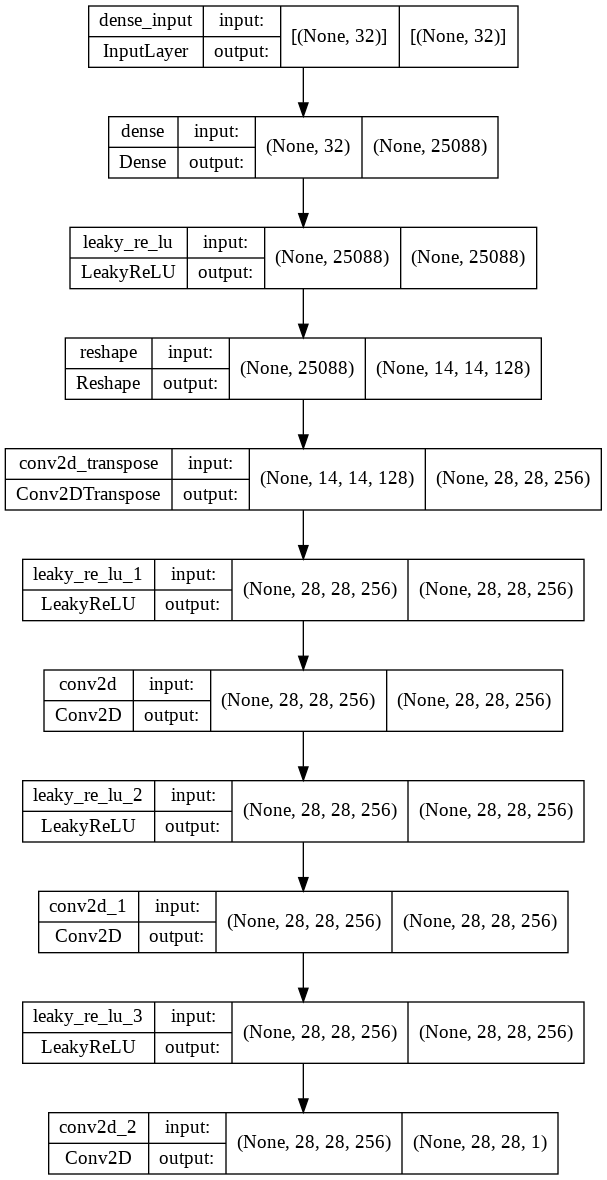

In [3]:
# 구조 시각화 - 생성자
from tensorflow.keras.utils import plot_model
plot_model(gen_model, show_shapes=True)

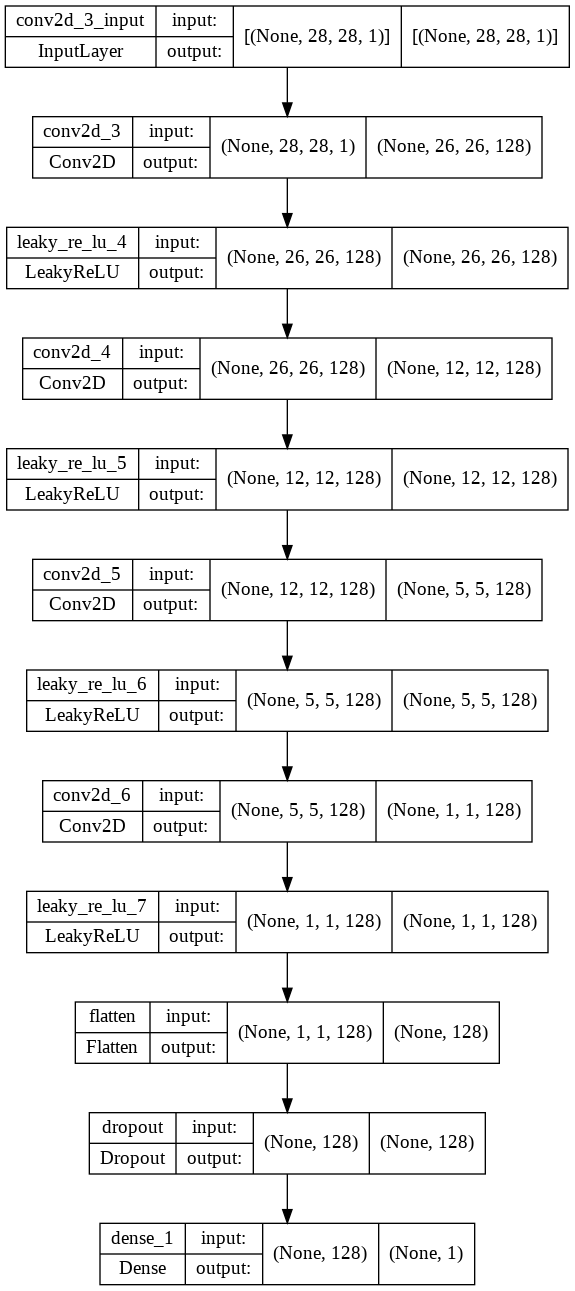

In [4]:
# 이건 판별자
plot_model(disc_model, show_shapes=True)

In [5]:
# 판별자는 생성자가 만든 결과물을 진품인지 가짜인지 두 종류로만 *분류*한다.
from tensorflow.keras.optimizers import RMSprop
disc_model.compile(optimizer = RMSprop(learning_rate=0.0008, clipvalue=1.0, decay=1e-8), # 원활한 학습을 위해 러닝 레이트도 낮추고, 학습율에 있어 감쇠도 적용했다
                      loss='binary_crossentropy')

In [6]:
# 판별자의 가중치가 훈련되지 않도록 설정. 판별자가 학습해 버리면 생성자가 아무리 가중치를 업데이트해도 -찐-을 가려낼 것이므로.
disc_model.trainable = False

gan_input = Input(shape=(latent_dim,))
gan_output = disc_model(gen_model(gan_input))
gan = Model(gan_input, gan_output)

gan.compile(optimizer = RMSprop(learning_rate=0.0004, clipvalue=1.0, decay=1e-8),
            loss='binary_crossentropy') # 여기서 가려내는 건 진위 여부

# 이건 시퀀셜로 못 만들었다. Layer.call 관련 오류가 떴는데 시간상 깊게 찾아보질 못함

In [10]:
import os 
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing import image

# mnist 데이터셋 불러오기
# 굳이 학습 레이블 들고 오는 이유는 원하는 번호 손글씨만 가져오기 위해서임.
# 진위 여부를 가리는 레이블은 밑에서 별도로 만든다.
(x_train, y_train),(_,_) = mnist.load_data()

# 4번 손글씨 이미지만 가져오자.
x_train = x_train[y_train.flatten() == 4]
x_train.shape

# 데이터 전처리
x_train = x_train.reshape((x_train.shape[0],) + (height,width,channels)).astype('float32') / 255.

iterations = 3000 # 시간상 3000번만 하기. 4천 번 돌리다가 터졌음
batch_size = 20
save_dir = './gan_images/'
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

In [11]:
# 진위 여부 관련 레이블 생성. 배치 사이즈 만큼의 진짜와 가짜를 넣을 예정이다.

labels = np.concatenate([np.ones((batch_size,1)), np.zeros((batch_size,1))])
labels += 0.05 * np.random.random(labels.shape)
# 근데 레이블에 이렇게 노이즈를 주는 이유는 잘 모르겠음

In [12]:
# 잠재 공간에서 무작위로 포인트를 샘플링
start = 0
for step in range(iterations):
  random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))
  # 랜덤 노이즈를 사용하여 generator 이미지를 생성(가짜 이미지를 디코딩)
  generated_images = gen_model.predict(random_latent_vectors)

  # 배치 사이즈만큼 진짜 한 묶음, 가짜 한 묶음 합쳐서 
  stop = start + batch_size
  real_images = x_train[start:stop]
  combined_images = np.concatenate([generated_images, real_images])

  # 위에서 만든 임시 레이블 부착해서 판별자 훈련
  d_loss = disc_model.train_on_batch(combined_images, labels)

  # 잠재 공간에서 무작위로 포인트를 샘플링 (위에서도 이 작업을 했지만 시드 고정이 아니라서 다른 값이 나온다)
  random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

  # 모든 타깃은 진짜로 설정, 판별자가 생성된 이미지를 모두 진짜 이미지라고 예측하도록 생성자의 가중치를 업데이트
  # gan 안에서 판별자는 동결되기 때문에 생성자만 업데이트, 결국 생성자는 판별자를 속이도록 훈련
  misleading_targets = np.zeros((batch_size,1))
  a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

  start += batch_size
  if start > len(x_train) - batch_size:
    start = 0

  if step % 100 == 0:
    gan.save_weights('gan.h5')

    print(f'스탭 {step}에서 판별자 손실: {d_loss} ')
    print(f'스탭 {step}에서 적대자 손실: {a_loss} ')

    # 생성된 이미지 하나를 저장
    img = image.array_to_img(generated_images[0] * 255.,scale=False)
    img.save(os.path.join(save_dir,'real_frog'+str(step)+'.png')) # 아 이거 안 바꿨네 ㅎㅎ 왜째서 리얼 프로그...

스탭 0에서 판별자 손실: 0.40293970704078674 
스탭 0에서 적대자 손실: 1.0989959239959717 
스탭 100에서 판별자 손실: 0.25672897696495056 
스탭 100에서 적대자 손실: 6.306199073791504 
스탭 200에서 판별자 손실: 0.0713970884680748 
스탭 200에서 적대자 손실: 5.720310211181641 
스탭 300에서 판별자 손실: -0.027520105242729187 
스탭 300에서 적대자 손실: 8.124621391296387 
스탭 400에서 판별자 손실: 0.10769512504339218 
스탭 400에서 적대자 손실: 18.186626434326172 
스탭 500에서 판별자 손실: -0.34580594301223755 
스탭 500에서 적대자 손실: 50.14277267456055 
스탭 600에서 판별자 손실: -0.19098061323165894 
스탭 600에서 적대자 손실: 39.24930191040039 
스탭 700에서 판별자 손실: 6.855079650878906 
스탭 700에서 적대자 손실: 26.036792755126953 
스탭 800에서 판별자 손실: 0.5533252954483032 
스탭 800에서 적대자 손실: 83.76728820800781 
스탭 900에서 판별자 손실: -0.12729114294052124 
스탭 900에서 적대자 손실: 59.449745178222656 
스탭 1000에서 판별자 손실: -1.2464319467544556 
스탭 1000에서 적대자 손실: 49.783409118652344 
스탭 1100에서 판별자 손실: 2.004767894744873 
스탭 1100에서 적대자 손실: 162.42706298828125 
스탭 1200에서 판별자 손실: 0.71706622838974 
스탭 1200에서 적대자 손실: 79.07173156738281 
스탭 1300에서 판별자 손실: -1.7157989740371

(10, 28, 28, 1)


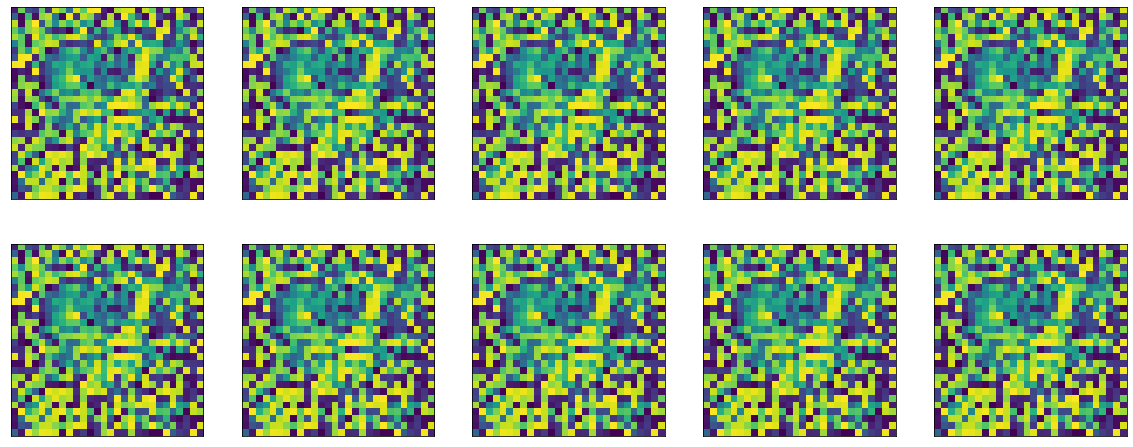

In [14]:
# 조작 이미지 보여주세용
import matplotlib.pyplot as plt
random_latent_vectors = np.random.normal(size=(10,latent_dim))
generated_images = gen_model.predict(random_latent_vectors)
print(generated_images.shape)

plt.figure(figsize=(20,8))

for i in range(generated_images.shape[0]):
  plt.subplot(2,5,i+1)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])

plt.show()